# Gene Network Analysis

This workbook will cover gene network analysis using large language models as an alternative to correlation analysis. Specifically, we will look at using scgpt, which is a foundation model for single-cell multi-omic data and has a wide range of capabilities.

We will use a model pretrained 10.3 million blood and bone marrow cells, since our dataset consists of B cells obtained from peripheral blood samples.

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/data/as8020/miniconda3/envs/scgpt_test2/lib/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/data/as8020/miniconda3/envs/scgpt_test2/lib/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


We need to set the parameters of the model for when we use it later in this workbook.

In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1000
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

Lets go through the parameters so they are better understood:
- set_seed is used to set the random seed for reproducibility.
- pad_token is a special token used for padding sequences, to ensure that all sequences are of the same length. Therefore it will be inserted where necessary to make sequences of unequal lengths equal.
- special_tokens is a list defining a set of special tokens the model may use, such as pad. Cls is commonly a classification token that represents the beginning of a sequence and is used to aggregate information for classification tasks. Eoc stands for 'end of converstion/content' and is used to denote the end of a sequence.
- n_hvg is a variable representing the number of highly variable genes to be considered.
- n_bins defines the number of bins to group continuous data into discrete intervals.
- mask_value defines a value for masking. Masking is a technique to ignore certain parts of the data, often used in sequence models to indicate positions in a sequence that should be ignored during training or evaluation.
- pad_value defines the value for padding sequences. Similar to mask_value, it indicates positions in the data that are not part of the original sequence and should be ignored.
- n_input_bins assignment set the number of input bins ensuring consistency throughout the code.

# Step 1: Load the Pre-Trained Model and Dataset

In [3]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path("/shared/as8020/recode/scgpt_blood_model")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /shared/as8020/recode/scgpt_blood_model/best_model.pt, the model args will override the config /shared/as8020/recode/scgpt_blood_model/args.json.


In [4]:
#Set up Pytorch model to run on specified device (CPU or GPU), intialise the model with specific parameters, 
#load pre-trained weight, and then transfer the model to the chosen device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

Loading params transformer_encoder.layers.8.norm2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.linear1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.linear2.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.linear2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm2.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm2.bias with shape torch.Size([512])
Loading params tr

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

Load dataset of interest.

In [5]:
# Specify data path; here we load the B cell dataset that we have been working with so far.
data_dir = Path("/shared/as8020/recode/dataset2")
adata = sc.read(
    str(data_dir / "Bcell_filtered.h5ad"), cache=True
)  
data_is_raw = False

In [6]:
adata

AnnData object with n_obs × n_vars = 3540 × 25198
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification.global', 'sample', 'donor_id', 'CHIP', 'LANE', 'ProjectID', 'MUTATION', 'MUTATION.GROUP', 'sex_ontology_term_id', 'HTOID', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'scType_celltype', 'pANN', 'development_stage_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'is_primary_data', 'tissue_type', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'citation', 'default_embedding', 'schema_

Check that the gene variable names are in the correct format i.e. gene symbol names and not Ensembl IDs.

In [7]:
adata.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,highly_variable,means,dispersions,dispersions_norm
feature_name,,,,,,,,,
MIR1302-2HG,False,MIR1302-2HG,NCBITaxon:9606,gene,1021,False,1.000000e-12,NaN,NaN
FAM138A,False,FAM138A,NCBITaxon:9606,gene,1219,False,1.000000e-12,NaN,NaN
OR4F5,False,OR4F5,NCBITaxon:9606,gene,2618,False,1.000000e-12,NaN,NaN
OR4F29,False,OR4F29,NCBITaxon:9606,gene,939,False,1.000000e-12,NaN,NaN
OR4F16,False,OR4F16,NCBITaxon:9606,gene,939,False,1.000000e-12,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TTTY17C,False,TTTY17C,NCBITaxon:9606,gene,776,False,1.000000e-12,NaN,NaN
SEPTIN14P23,False,SEPTIN14P23,NCBITaxon:9606,gene,1192,False,2.503351e-04,-0.120703,-1.405214
CDY1,False,CDY1,NCBITaxon:9606,gene,2670,False,1.000000e-12,NaN,NaN


In [8]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # step 3 whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # step 4 whether to log1p the normalised data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


# Step 2: Retrieve Scgpt's Gene Embeddings

Overall, the pre-trained foundation model contains 30+K genes. 
Here for simplicity, we focus on a subset of HVGs specific to the data at hand.

In [9]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [10]:
# Filter on the intersection between the Blood HVGs found and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 962 genes.


In [11]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 1095850.20it/s]


# Step 3: Extract gene programmes from gene embedding network

Perform Louvain clustering on the gene embedding network.

In [12]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

In [13]:
gdata

AnnData object with n_obs × n_vars = 962 × 512
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [14]:
metagenes

defaultdict(list,
            {'32': ['ZNF880', 'SNHG21', 'APOM', 'SC5D'],
             '214': ['ZNF837', 'SMYD5'],
             '215': ['ZNF713', 'MIR762HG'],
             '254': ['ZNF618', 'ZNF235'],
             '144': ['ZNF608', 'APBB2', 'ZNF43'],
             '57': ['ZNF594-DT', 'TSPYL5', 'ZNF530', 'MTFR2'],
             '120': ['ZNF528-AS1', 'WDR27', 'CORT'],
             '37': ['ZNF426', 'ZFP14', 'TTC28-AS1', 'ZNF76'],
             '182': ['ZNF415', 'KRCC1', 'PTPRN2'],
             '109': ['ZNF391', 'ZCWPW1', 'IFT88'],
             '74': ['ZNF318', 'SIPA1L3', 'KBTBD8', 'GUCD1'],
             '21': ['ZNF274', 'OMA1', 'POLM', 'HELQ', 'LINC00339'],
             '91': ['ZNF140', 'SMIM8', 'ZBED5-AS1', 'FCF1'],
             '99': ['ZMYND8', 'ITPR1', 'CDKAL1'],
             '268': ['ZMAT1', 'EFCAB13'],
             '12': ['ZFAND2A', 'HSPB1', 'DNAJB1', 'HSPA1A', 'HSPA6', 'HSPA1B'],
             '217': ['ZEB2-AS1', 'PTCH2'],
             '95': ['ZDHHC19', 'SERHL2', 'NEK8'],
             

Filter on clusters with 5 or more genes

In [15]:
# Obtain the set of gene programmes from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [16]:
# Here are the gene programmes identified
mgs

{'21': ['ZNF274', 'OMA1', 'POLM', 'HELQ', 'LINC00339'],
 '12': ['ZFAND2A', 'HSPB1', 'DNAJB1', 'HSPA1A', 'HSPA6', 'HSPA1B'],
 '5': ['ZBTB16', 'TLE1', 'TBC1D5', 'CRIM1', 'PRKCB', 'VAV3', 'MCTP2'],
 '22': ['TRIM23', 'ERV3-1', 'RNGTT', 'MBD5', 'CCNT1'],
 '1': ['TNFRSF13B',
  'FCRL2',
  'PNOC',
  'S100B',
  'LINC01781',
  'CD1C',
  'LINC01857',
  'OSBPL10'],
 '10': ['TIMP1', 'VSIR', 'AIF1', 'FABP5', 'CST3', 'LST1'],
 '25': ['TACC3', 'MKI67', 'CKS2', 'CENPF', 'SMC4'],
 '2': ['SP2',
  'H2AC21',
  'H2AC11',
  'H2BC13',
  'H2BC18',
  'H2BC4',
  'H2BC7',
  'H3C3'],
 '17': ['SEMA3C', 'PID1', 'EMP1', 'CREB5', 'CD109'],
 '13': ['S100A8', 'FCN1', 'S100A12', 'LYZ', 'MNDA', 'S100A9'],
 '16': ['RSPH1', 'CFAP126', 'IQCG', 'MORN2', 'MOK'],
 '0': ['TXNDC5',
  'IGHA2',
  'IGLC3',
  'IGHA1',
  'IGHG4',
  'JCHAIN',
  'IGHG1',
  'IGHG3',
  'IGLC2'],
 '9': ['TRAC', 'GIMAP7', 'CD3G', 'CD3D', 'CD2', 'IL7R'],
 '19': ['RAB3IP', 'DZIP3', 'ALDH7A1', 'PGM2L1', 'PAX8-AS1'],
 '18': ['RAB33B-AS1', 'MZF1-AS1', 'SDR42E2',

# Step 4: Visualise Network Connectivity within Desired Gene Programme

In [17]:
# Retrieve gene programme 3
GP_genes = mgs['3']
print(GP_genes)
# Initialise an empty list to collect DataFrames
df_list = []
# Compute cosine similarities among genes in this gene programme
for i in tqdm.tqdm(GP_genes):
    df = embed.compute_similarities(i, GP_genes)
    df['Gene1'] = i
    df_list.append(df)
# Concatenate all the DataFrames in the list
df_GP = pd.concat(df_list, ignore_index=True)
# Filter out edges from each gene to itself and sort by 'Gene'
df_GP_sub = df_GP[df_GP['Similarity'] < 0.99].sort_values(by='Gene')
# Display the resulting DataFrame
print(df_GP_sub)

['MX1', 'HERC5', 'XAF1', 'IFI44L', 'IFIT3', 'MX2', 'EPSTI1', 'PLSCR1']


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 236.27it/s]

      Gene  Similarity   Gene1
60  EPSTI1    0.225607  PLSCR1
45  EPSTI1    0.188223     MX2
6   EPSTI1    0.256395     MX1
35  EPSTI1    0.274948   IFIT3
29  EPSTI1    0.241366  IFI44L
19  EPSTI1    0.254587    XAF1
14  EPSTI1    0.119632   HERC5
31   HERC5    0.168532  IFI44L
55   HERC5    0.119632  EPSTI1
47   HERC5    0.163126     MX2
38   HERC5    0.202499   IFIT3
23   HERC5    0.168315    XAF1
63   HERC5    0.091875  PLSCR1
7    HERC5    0.174051     MX1
1   IFI44L    0.372201     MX1
17  IFI44L    0.337581    XAF1
59  IFI44L    0.232156  PLSCR1
11  IFI44L    0.168532   HERC5
34  IFI44L    0.296725   IFIT3
52  IFI44L    0.241366  EPSTI1
41  IFI44L    0.306452     MX2
44   IFIT3    0.198912     MX2
49   IFIT3    0.274948  EPSTI1
9    IFIT3    0.202499   HERC5
28   IFIT3    0.296725  IFI44L
3    IFIT3    0.313495     MX1
58   IFIT3    0.240587  PLSCR1
20   IFIT3    0.240173    XAF1
10     MX1    0.174051   HERC5
50     MX1    0.256395  EPSTI1
33     MX1    0.313495   IFIT3
25     M

In [18]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_GP_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

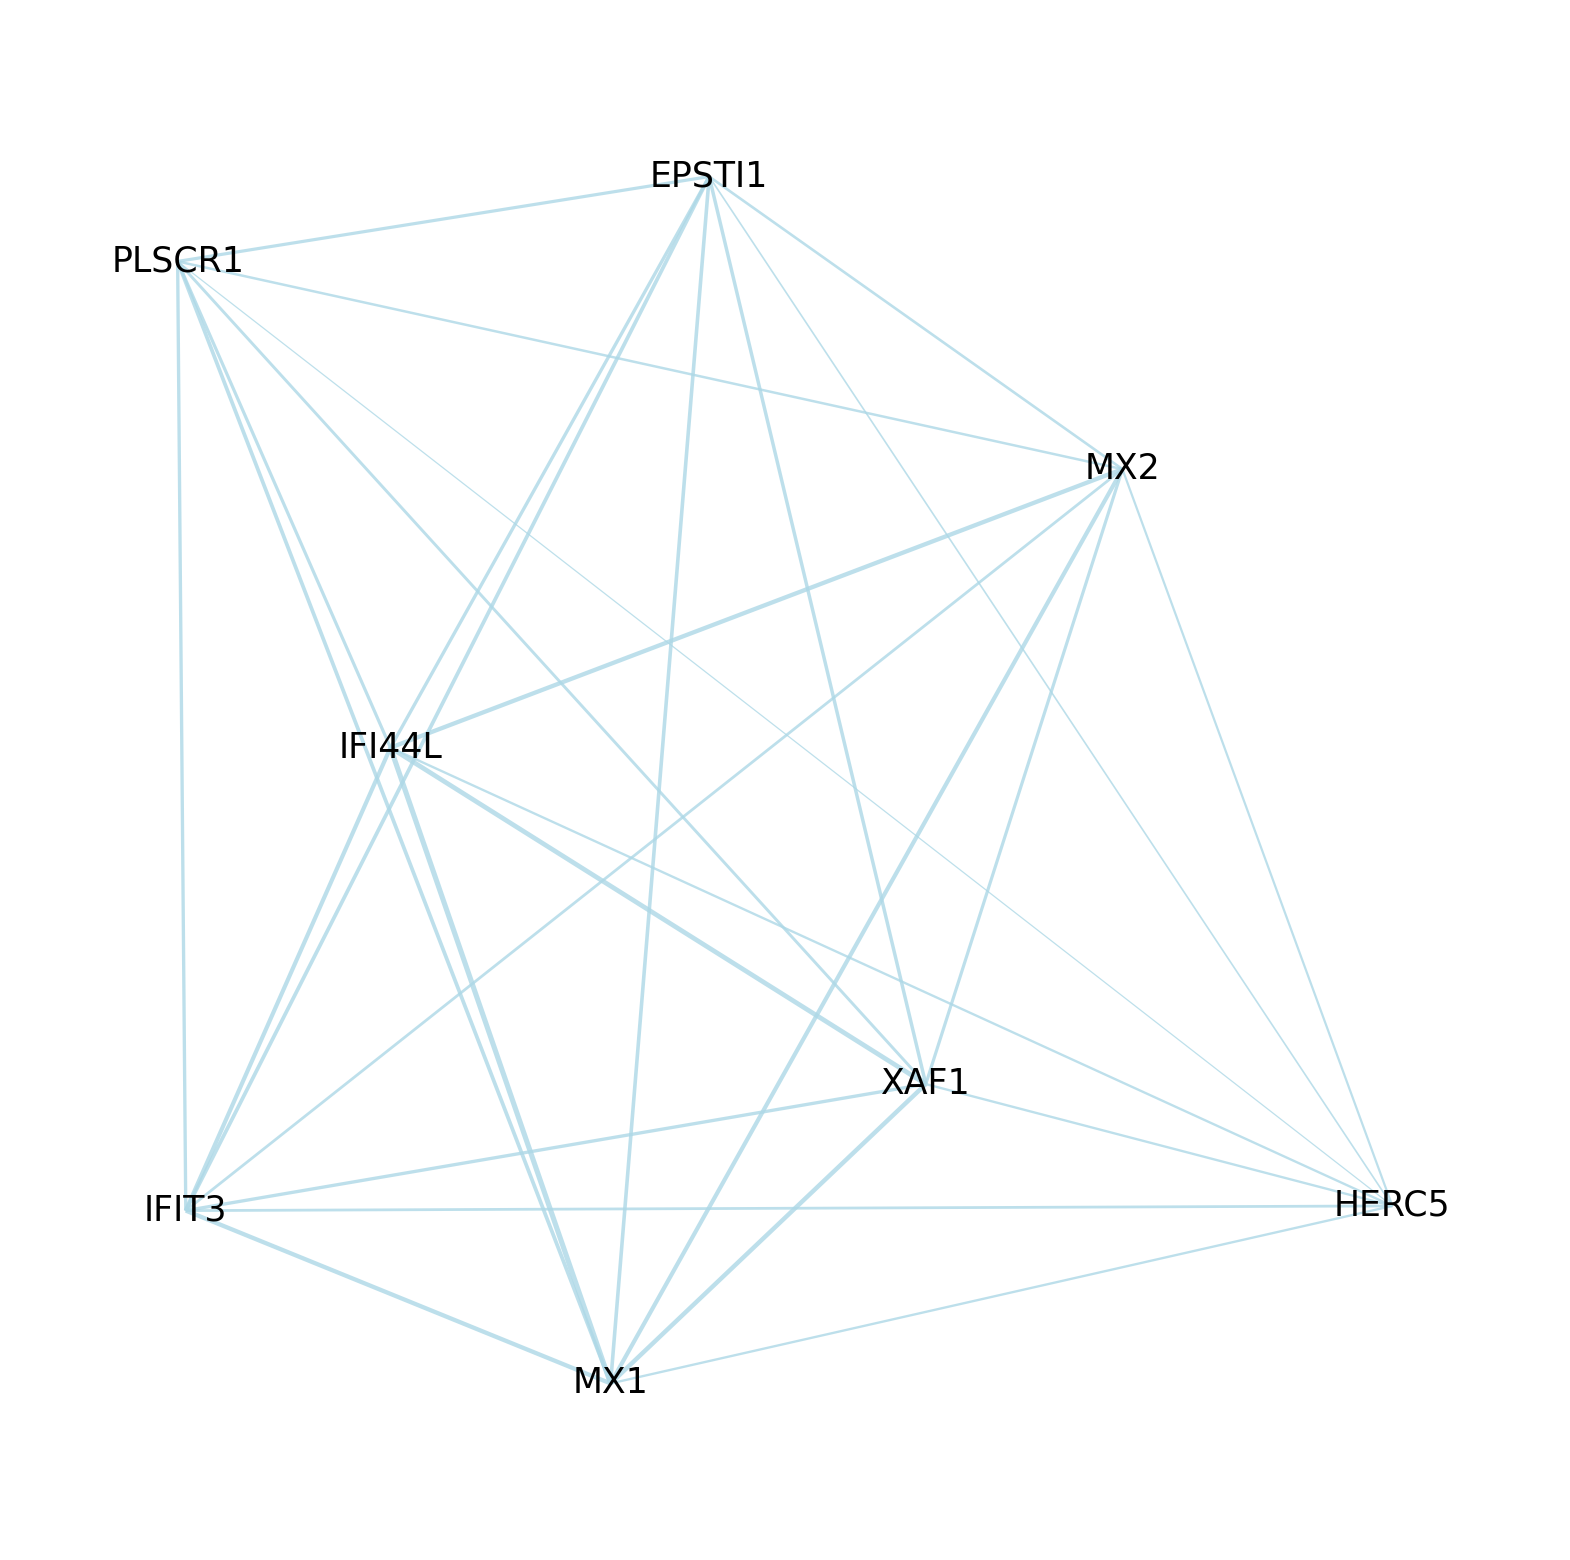

In [19]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()


# Step 6: Reactome Pathway Analysis

Reactome pathway is another form of pathway analysis that can be carried out on the data.

In [20]:
# Meta info about the number of terms (tests) in the databases
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])

In [21]:
# Select desired database for query; here use Reactome as an example
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum()
# p-value correction for total number of tests done
p_thresh = 0.05/m

In [22]:
# Perform pathway enrichment analysis using the gseapy package in the Reactome database
df_list = []
enr_Reactome = gp.enrichr(gene_list=GP_genes,
                          gene_sets=databases,
                          organism='Human', 
                          outdir='test/enr_Reactome',
                          cutoff=0.5)
out = enr_Reactome.results
out = out[out['P-value'] < p_thresh]
df_list.append(out)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)
df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2022,Interferon Signaling R-HSA-913531,5/200,5.197809e-09,8.836276e-08,0,0,169.205128,3227.592653,HERC5;MX2;MX1;XAF1;IFIT3
1,Reactome_2022,Interferon Alpha/Beta Signaling R-HSA-909733,4/72,1.068672e-08,9.083711e-08,0,0,293.000000,5377.799365,MX2;MX1;XAF1;IFIT3
2,Reactome_2022,Cytokine Signaling In Immune System R-HSA-1280215,5/702,2.693582e-06,1.189224e-05,0,0,46.138211,591.705896,HERC5;MX2;MX1;XAF1;IFIT3
3,Reactome_2022,ISG15 Antiviral Mechanism R-HSA-1169408,3/75,2.798175e-06,1.189224e-05,0,0,166.000000,2122.566166,HERC5;MX2;MX1
4,Reactome_2022,Antiviral Mechanism By IFN-stimulated Genes R-...,3/83,3.801759e-06,1.292598e-05,0,0,149.340000,1863.770163,HERC5;MX2;MX1


External Reading:

- SCGPT paper: https://www.nature.com/articles/s41592-024-02201-0
- Feature selection: https://bioconductor.org/books/3.15/OSCA.basic/feature-selection.html
- P-values: https://www.nature.com/articles/nmeth.2900
- Community detection algorithms: https://www.nature.com/articles/s41598-019-41695-z
- Reactome: https://reactome.org/

Exercises:
1. Describe the process of loading the pre-trained scGPT model. What are the key parameters used?
2. Explain the significance of the n_hvg and n_bins parameters used in the preprocessing pipeline.
3. Why is it important to filter the model gene embeddings to match the HVGs found in the input dataset?
4. Describe the process of constructing the gene embedding network and performing Louvain clustering. What is the role of the resolution parameter?
5.  Explain how the cosine similarity among genes in a specific gene programme is computed.
6. What is the purpose of performing pathway enrichment analysis in this context?
7. Explain the significance of the p-value correction applied during the pathway enrichment analysis.
8.  Change the resolution parameter for the Louvain clustering step and analyse how the number of identified gene programmes changes. Plot the distribution of gene programmes for different resolution values.
9. Choose a different gene programme and create a similar gene similarity network to visualise.
10. Perform pathway enrichment analysis using a different database, such as GO_Biological_Process_2021 as well as report the top enriched pathways/processes and their significance levels.

Answers:


Answer 8:

In [ ]:
# Define a range of resolution values to test


Answer 9:

In [ ]:
# Retrieve gene programme

Answer 10: 

In [ ]:
# Set pandas options to display the entire term
pd.set_option('display.max_colwidth', None)

# Select desired database for query
